### Libraries

In [14]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
from lib import analysis, enrich, data_generation
from scipy import stats
from scipy import io
from tqdm import tqdm
import os

### Import data

In [2]:
user_col = 'user'
item_col = 'item'
predict_col = 'rating'
location = 'data/'

Real data.

In [3]:
fairbook_ratings = pd.read_csv(
    location + 'fairbook/fairbook_events.csv', header=0,
)

In [4]:
mat = io.loadmat(location+"epinion/epinion_events.mat")
mat_df = pd.DataFrame(mat['rating_with_timestamp'])
mat_df.columns = [user_col, item_col, '.', predict_col, '..', '...']
epinion_ratings = mat_df[[user_col,item_col,predict_col]].drop_duplicates(subset = [user_col,item_col], keep='last')

In [5]:
ml1m_ratings = pd.read_csv(
    location+'movielens_1m/ml1m_events.dat', header=None, sep="::", engine="python"
).drop(3, axis=1)
ml1m_ratings.columns = [user_col, item_col, predict_col]

Synthetic data.

In [6]:
data_strategies = [
    "uniformly_random",
    "popularity_good",
    "popularity_bad",
    "popularity_good_for_bp_ur",
    "popularity_bad_for_bp_ur",
]

In [20]:
synthetic_data = []
for i in tqdm(range(len(data_strategies))):
    ds = data_strategies[i]
    ratings = pd.read_csv('data/'+ds+'/'+ds+'.csv')
    synthetic_data.append(ratings)

100%|███████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 47.10it/s]


### Analyze data

In [93]:
def do_analysis(ratings,perc_top = 0.2):
    # analysis.users_and_items(ratings, user_col, item_col)
    user_dist, num_users = analysis.user_distribution(ratings, user_col, item_col, verbose=False)
    item_dist, num_items = analysis.item_distribution(ratings, user_col, item_col, verbose=False)
    item_rating_dist = analysis.item_rating(ratings,item_col, predict_col, verbose=False)
    
    df_item_dist = pd.DataFrame(item_dist)
    df_item_dist.columns = ['count']
    full_item_dist = pd.merge(df_item_dist, item_rating_dist, left_index=True, right_index=True)

    font = {'size'   : 15}
    matplotlib.rc('font', **font)
    
    # plot: item rating vs popularity
    
    x = full_item_dist['count'].values
    y = full_item_dist.rating.values
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    line = slope * np.array(x) + intercept
    # Calculate the point density
    # print('hi')
    # xy = np.vstack([x,y])
    # z = stats.gaussian_kde(xy)(xy)
    fig, axs = plt.subplots(1, 1)
    axs.plot(x, line)
    axs.set_xlabel("Item popularity",fontsize=20)
    axs.set_ylabel("Item average rating",fontsize=20)
    axs.set_title('Correlation: ' + str(round(r_value,2)),fontsize=20)
    # Sort the points by density, so that the densest points are plotted last
    # idx = z.argsort()
    # x, y, z = x[idx], y[idx], z[idx]
    # axs.scatter(x, y, c=z, s=50)
    axs.scatter(x, y, s=50)

    uc, ic = enrich.calculate_userKNN_characteristics(ratings, user_dist, item_dist, user_col, item_col, predict_col,  df_item_dist, divide_by = 'pop_item_fraq')

    num_top = int(perc_top * num_users) + 1
    bp_users = uc.sort_values(by = 'count', ascending=False).iloc[:num_top]
    item_bp_rat_bp = analysis.item_rating(ratings[ratings.user.isin(bp_users.index)], item_col, predict_col)
    item_bp_pop_rat = pd.merge(df_item_dist, item_bp_rat_bp, left_index=True, right_index=True)
    full_item_dist_but_only_bp_items = pd.merge(full_item_dist, item_bp_rat_bp, left_index=True, right_index=True)
    
    print(num_items, len(item_bp_pop_rat)) # posa items ekanan rate oi users me ta megala profile
    # plot: item rating vs popularity for bp users
    print(full_item_dist_but_only_bp_items)
    x = item_bp_pop_rat['count'].values
    y = item_bp_pop_rat.rating.values
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    line = slope * np.array(x) + intercept
    # Calculate the point density
    # print('hi')
    # xy = np.vstack([x,y])
    # z = stats.gaussian_kde(xy)(xy)
    fig, axs = plt.subplots(1, 1)
    axs.plot(x, line)
    axs.set_xlabel("Item popularity",fontsize=20)
    axs.set_ylabel("Item average rating for users with big profiles",fontsize=20)
    axs.set_title('Correlation: ' + str(round(r_value,2)),fontsize=20)
    # Sort the points by density, so that the densest points are plotted last
    # idx = z.argsort()
    # x, y, z = x[idx], y[idx], z[idx]
    # axs.scatter(x, y, c=z, s=50)
    axs.scatter(x, y, s=50)

296277 247437
        count  rating_x  rating_y
122      1742  2.588978  2.669279
633      1229  3.460537  3.198614
51       1201  4.388010  4.394286
666       847  2.709563  2.774194
386       743  1.970390  1.865103
...       ...       ...       ...
95004       1  4.000000  4.000000
84763       1  5.000000  5.000000
82714       1  5.000000  5.000000
88857       1  5.000000  5.000000
173739      1  5.000000  5.000000

[247437 rows x 3 columns]


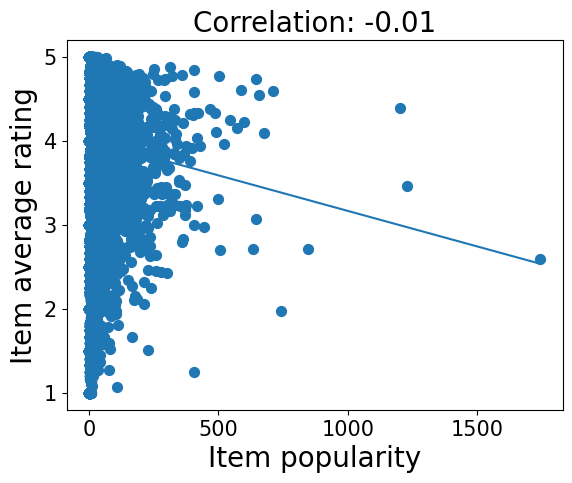

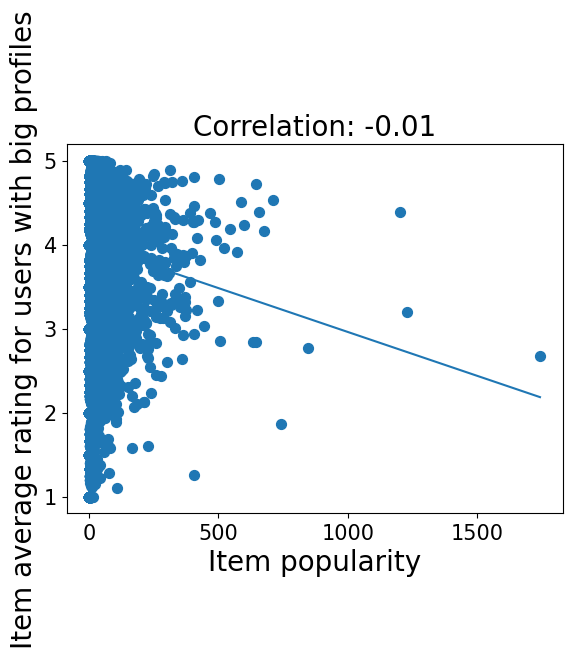

In [101]:
do_analysis(epinion_ratings, perc_top = 0.2)

296277 225486
        count  rating_x  rating_y
122      1742  2.588978  2.705882
633      1229  3.460537  3.017391
51       1201  4.388010  4.366460
666       847  2.709563  2.822785
386       743  1.970390  1.843750
...       ...       ...       ...
95004       1  4.000000  4.000000
84763       1  5.000000  5.000000
82714       1  5.000000  5.000000
88857       1  5.000000  5.000000
173739      1  5.000000  5.000000

[225486 rows x 3 columns]


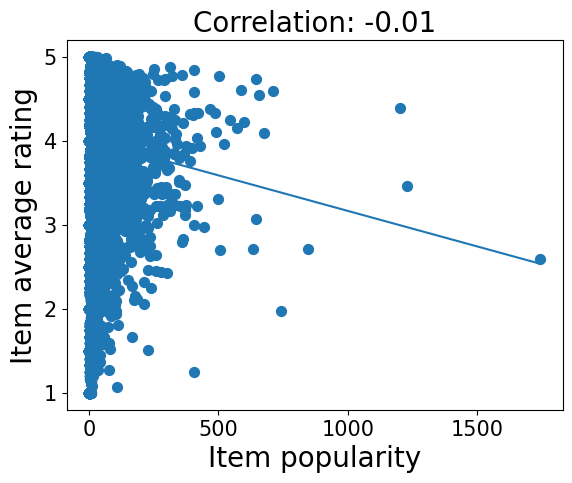

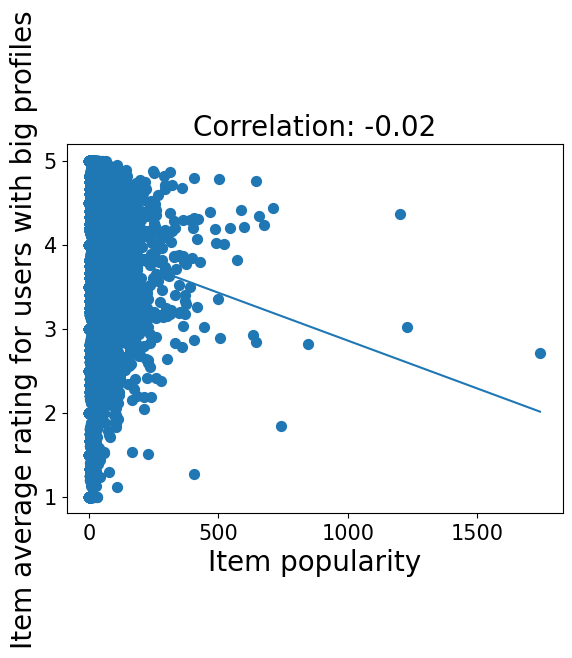

In [100]:
do_analysis(epinion_ratings, perc_top = 0.1)